# Intégration des données dans un data warehouse
# BUT SD 2
##### Par: Tim Touviot, Éloïse Serrand, Julien Renoult, Dalyop Yop
###### 07/12/2023 - 22/12/2023

### Charger les librairies pour recueillir des données de la base de données et faire de l'analyse

In [1]:
import mysql.connector as mdb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr

/usr/local/tp_python/lib/python3.10/site-packages/numpy/lib/scimath.py:46: RuntimeWarning: divide by zero encountered in log
  _ln2 = nx.log(2.0)


### Charger les informations pour se connecter à la base 

#### Lire le fichier contenant les informations pour se connecter

Afin d'éviter d'écrire explicitement le mot de passe, nous avons décidé de stocker les infos utilisateur dans un fichier txt. Le format à écrire est :
- DBUSER : nom d'utilisateur
- DBPASS : mot de passe
- DBHOST : serveur
- DBNAME : nom de la base de données

In [2]:
def txtfileliste(doc):
    """
    Cette fonction permet de lire un fichier texte vers des listes en indiquant le chemin relatif.
    """
    f = open(doc, "r", encoding="UTF-8")
    lines = f.readlines()
    f.close()
    data = []
    for i in lines:
        data += [i.strip()]
    return data

#### Récupération des mots de passes

In [3]:
login = []

for i in txtfileliste("login.txt"):
    login.append([i][0].split()[2])

DBUSER = login[0]
DBPASS = login[1]
DBHOST = login[2]
DBNAME = login[3]
DBPORT = 3306


#### Sélection des données dans la base

Dans cette partie, nous allons sélectionner dans la base de données les données que nous avons besoin. Dans notre cas, nous sélectionnons les données datant entre 2012 et 2021 pour faire notre étude.

In [4]:
def recueillir(requete):
    """
    Cette fonction permet de recueillir des données à l'aide de l'argument 'requete' qui est la requête SQL à exécuter.
    """
    try:
        pass
        db = mdb.connect(
            host = DBHOST,
            port = DBPORT,
            user = DBUSER,
            passwd = DBPASS,
            db = DBNAME
        )
        cur = db.cursor() #permettre d'exécuter des requêtes sur notre base de données

        cur.execute(requete) # exécuter la requête
        data = cur.fetchall() # retourner les données
        return data

        db.commit()
        print("Connecté *\o/* ")

    except mdb.Error as e:
        print("Erreur :-( ", e)

    finally: # ce bloc sera exécuté quoi qu'il en soit
        cur.close()
        db.close()

# Données pour l'analyse entre 2012 et 2021
annees_analyse = recueillir("""
SELECT me.date, me.station, me.type, ty.unite, me.valeur FROM MESURE AS me 
INNER JOIN TYPE AS ty ON me.type = ty.type  
WHERE YEAR(date) BETWEEN '2012' AND '2021';
""")

# Vérification du succès de l'opération
print(annees_analyse[0:5])

# Transformation en dataframe
annees_analyse = pd.DataFrame(annees_analyse, columns = ["date", "station", "type", "unite", "valeur"])

# Exportation des données au format csv
annees_analyse.to_csv("../Data/data_annees.csv", index = False)

[(datetime.datetime(2012, 1, 1, 0, 0), 'athletic stadium', 'DiffTemp 2-8 m', 'deg.C', Decimal('0.0182740000')), (datetime.datetime(2012, 1, 1, 0, 0), 'athletic stadium', 'Temp', 'deg.C', Decimal('10.6829070000')), (datetime.datetime(2012, 1, 1, 0, 0), 'athletic stadium', 'Wind Direction 10 m', 'deg.M', Decimal('236.3330080000')), (datetime.datetime(2012, 1, 1, 0, 0), 'athletic stadium', 'Wind Speed 10 m', 'm/s', Decimal('6.9670560000')), (datetime.datetime(2012, 1, 1, 0, 0), 'groundhog2', 'PM10', 'ug/m3', Decimal('2.2533310000'))]


### Importation des données

In [5]:
# Importation des données
dataset = pd.read_csv("../Data/data_annees.csv", sep=",", decimal = ".")

# Conversion en date
dataset["date"] = pd.to_datetime(dataset["date"])

# Vérification du succès de l'opération
dataset.head(n = 10)

date           station                 type  unite  \
0 2012-01-01 00:00:00  athletic stadium       DiffTemp 2-8 m  deg.C   
1 2012-01-01 00:00:00  athletic stadium                 Temp  deg.C   
2 2012-01-01 00:00:00  athletic stadium  Wind Direction 10 m  deg.M   
3 2012-01-01 00:00:00  athletic stadium      Wind Speed 10 m    m/s   
4 2012-01-01 00:00:00        groundhog2                 PM10  ug/m3   
5 2012-01-01 00:00:00        groundhog2                PM2.5  ugm-3   
6 2012-01-01 01:00:00  athletic stadium       DiffTemp 2-8 m  deg.C   
7 2012-01-01 01:00:00  athletic stadium                 Temp  deg.C   
8 2012-01-01 01:00:00  athletic stadium  Wind Direction 10 m  deg.M   
9 2012-01-01 01:00:00  athletic stadium      Wind Speed 10 m    m/s   

       valeur  
0    0.018274  
1   10.682907  
2  236.333008  
3    6.967056  
4    2.253331  
5    0.733333  
6    0.015948  
7   10.052567  
8  235.220459  
9    7.150635

Les données désormais importées, nous pouvons commencer l'analyse sur deux axes principaux :
- L'augmentation de la température et des pics de pollutions en fonction du temps
- L'analyse des types/unités de pollution

# Analyse exploratoire

## 1. Augmentation de la température en fonction du temps et de l'Ozone

### Création d'une fonction permettant de récupérer pour une année, les mesures d'un type

Pour faire l'analyse sur les températures, nous allons sélectionner les données nécessaires à cette analyse notamment ceux en lien avec les températures.

In [6]:
def recuperation_annee(annee, type_mes):
    """
    Cette fonction permet de sélectionner les données récupérées selon plusieurs arguments :
    - annee : l'année où on doit rechercher les données
    - type_mes : le type de mesure à sélectionner
    """
    # INITIALISATION #######
    start_date = annee+"-01-01"
    end_date = annee+"-12-31"
    ########################
    
    # Récupération des données sur le type de mesure et l'année demandée
    data_annee = dataset[(dataset['date'] >= start_date) & (dataset['date'] <= end_date) & (dataset["type"] == type_mes)]
    
    # Sélection des colonnes d'intérêts
    data_annee = data_annee[["date", "type", "valeur"]]
    
    # Ajout de la colonne des date du jour sans les horaires
    data_annee = data_annee.assign(date_jour = data_annee["date"].dt.date)
    
    # Renvoie des données
    return data_annee

In [7]:
# Sélectionner les températures relevées en 2012
data_2012 = recuperation_annee("2012", "Temp")

# Vérification du succès de l'opération
data_2012.head(n = 5)

date  type     valeur   date_jour
1  2012-01-01 00:00:00  Temp  10.682907  2012-01-01
7  2012-01-01 01:00:00  Temp  10.052567  2012-01-01
13 2012-01-01 02:00:00  Temp   9.422226  2012-01-01
19 2012-01-01 03:00:00  Temp   8.791885  2012-01-01
25 2012-01-01 04:00:00  Temp   8.671585  2012-01-01

### Température 2017

In [8]:
# Sélectionner les températures relevées en 2017
data_2017 = recuperation_annee("2017", "Temp")

# Vérification du succès de l'opération
data_2017.head(n = 5)

date  type    valeur   date_jour
244079 2017-01-01 00:00:00  Temp  8.699997  2017-01-01
244088 2017-01-01 01:00:00  Temp  8.800003  2017-01-01
244098 2017-01-01 02:00:00  Temp  8.600006  2017-01-01
244108 2017-01-01 03:00:00  Temp  8.300003  2017-01-01
244118 2017-01-01 04:00:00  Temp  7.099998  2017-01-01

### Température 2022

In [9]:
# Sélectionner les températures relevées en 2021
data_2021 = recuperation_annee("2021", "Temp")

# Vérification du succès de l'opération
data_2021.head(n = 5)

date  type    valeur   date_jour
1092583 2021-01-01 00:00:00  Temp  0.290000  2021-01-01
1092623 2021-01-01 01:00:00  Temp  0.903000  2021-01-01
1092663 2021-01-01 02:00:00  Temp  1.906000  2021-01-01
1092701 2021-01-01 03:00:00  Temp  3.002998  2021-01-01
1092739 2021-01-01 04:00:00  Temp  3.612999  2021-01-01

 ### Température générale pour 2012, 2017 et 2022
 
 Pour pouvoir faire la moyenne des températures, nous avons créé une fonction permettant de calculer la moyenne par mois pour une année.

In [10]:
def moy_mois(donnees):
    """
    Cette fonction permet de calculer les moyennes de mesure par mois pour une année.
    Elle est composé d'un seul argument qui est :
    - donnees : dataframe contenant les colonnes ['date', 'type', 'valeur', 'date_jour'] 
    et ne contenant que les données d'une année.
    """
    
    # Ajout de la colonne du mois
    donnees = donnees.assign(mois = donnees["date"].dt.month)
    
    #print(donnees)
    
    # Grouper les données par mois
    data_mois = donnees.groupby(["mois"])
    
    #print(data_mois)
    
    # Calcul des moyennes par mois
    data_mois = data_mois.mean()
    
    #print(data_mois)
    
    # Retourne les moyennes des mesures par mois
    return data_mois["valeur"]

### Application de la fonction pour 2012, 2017, 2021

In [11]:
valeur_2012 = moy_mois(data_2012)
print(valeur_2012)

valeur_2017 = moy_mois(data_2017)
print(valeur_2017)

valeur_2021 = moy_mois(data_2021)
print(valeur_2021)

mois
1      4.191035
2      3.383008
3      7.284769
4      6.038673
5     10.532268
6     12.471748
7     14.516605
8     15.386791
9     12.247904
10     8.343897
11     5.747749
12     3.553361
Name: valeur, dtype: float64
mois
1      4.710081
2      6.364881
3      8.933602
4      9.505278
5     13.502823
6     16.693333
7     16.871909
8     16.193011
9     13.709445
10    12.916263
11     7.563611
12     5.281137
Name: valeur, dtype: float64
mois
1      4.017146
2      5.210037
3      8.042496
4      7.226379
5     10.580993
6     16.364434
7     18.209506
8     16.659037
9     16.518358
10    12.639986
11     8.699372
12     6.213979
Name: valeur, dtype: float64


/tmp/ipykernel_9603/1536219880.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_mois = data_mois.mean()
/tmp/ipykernel_9603/1536219880.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_mois = data_mois.mean()
/tmp/ipykernel_9603/1536219880.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_mois = data_mois.mean()


### Réunion de ces données dans une dataframe

In [12]:
# Création du dataframe à l'aide d'un dictionnaire
donnees = {'date': pd.date_range(start='2021-01-01', periods=12, freq='M'),
        'value_2012': valeur_2012,
        'value_2017': valeur_2017,
        'value_2021': valeur_2021}

df = pd.DataFrame(donnees)

# Vérification du succès de l'opération
df

date  value_2012  value_2017  value_2021
mois                                               
1    2021-01-31    4.191035    4.710081    4.017146
2    2021-02-28    3.383008    6.364881    5.210037
3    2021-03-31    7.284769    8.933602    8.042496
4    2021-04-30    6.038673    9.505278    7.226379
5    2021-05-31   10.532268   13.502823   10.580993
6    2021-06-30   12.471748   16.693333   16.364434
7    2021-07-31   14.516605   16.871909   18.209506
8    2021-08-31   15.386791   16.193011   16.659037
9    2021-09-30   12.247904   13.709445   16.518358
10   2021-10-31    8.343897   12.916263   12.639986
11   2021-11-30    5.747749    7.563611    8.699372
12   2021-12-31    3.553361    5.281137    6.213979

### Moyenne des températures pour les années 2012, 2017 et 2021

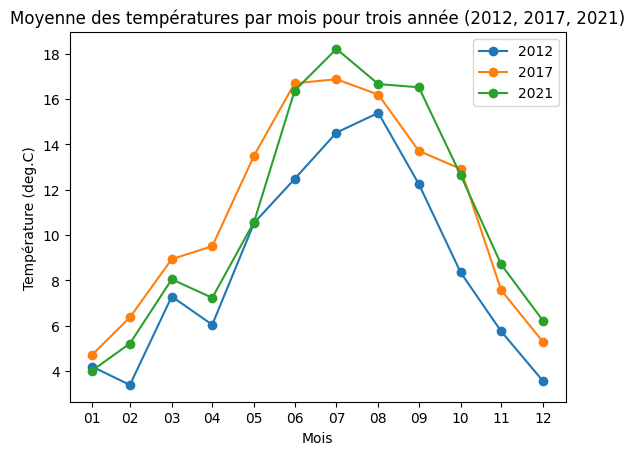

In [13]:
# Tracé des moyennes de température pour 2012, 2017 et 2021
plt.plot(df['date'], df['value_2012'], label='2012', marker='o')

plt.plot(df['date'], df['value_2017'], label='2017', marker='o')

plt.plot(df['date'], df['value_2021'], label='2021', marker='o')

# Ajout des titres et d'étiquettes
plt.title('Moyenne des températures par mois pour trois année (2012, 2017, 2021)')
plt.xlabel('Mois')
plt.ylabel('Température (deg.C)')

# Affichage de la légende
plt.legend()

# Modification des labels de l'axe des X
plt.xticks(df['date'], df['date'].dt.strftime('%m'))

# Affichage de la courbe
plt.show()

On peut voir dans ce graphique que la température moyenne augmente au fur et à mesure des années avec des différences de températures par mois de plus de 2 degrés Celsius.

### Moyenne des mesures de pollution entre 2019 et 2021 (Ozone)

Regardons les mesures de pollution sur l'Ozone entre 2019 et 2021. Pour ce faire, nous allons répéter les mêmes étapes que nous avons faits précedemment sauf qu'ici, nous allons récupérer les données concernant l'élément d'Ozone pour les années 2019, 2020 et 2021.

In [14]:
# Sélectionner les mesures des microsplastiques relevées en 2021
data_2021 = recuperation_annee("2021", "Ozone")

data_2021.head(n = 5)

date   type     valeur   date_jour
1092594 2021-01-01 00:00:00  Ozone  17.924988  2021-01-01
1092607 2021-01-01 00:00:00  Ozone   2.549999  2021-01-01
1092634 2021-01-01 01:00:00  Ozone  17.625000  2021-01-01
1092647 2021-01-01 01:00:00  Ozone   4.050003  2021-01-01
1092672 2021-01-01 02:00:00  Ozone  16.149994  2021-01-01

In [15]:
# Sélectionner les mesures des microsplastiques relevées en 2020
data_2020 = recuperation_annee("2020", "Ozone")

# Vérification du succès de l'opération
data_2020.head(n = 5)

date   type     valeur   date_jour
735196 2020-01-01 00:00:00  Ozone  18.450012  2020-01-01
735204 2020-01-01 00:00:00  Ozone  12.100006  2020-01-01
735235 2020-01-01 01:00:00  Ozone  19.475006  2020-01-01
735244 2020-01-01 01:00:00  Ozone  14.525009  2020-01-01
735277 2020-01-01 02:00:00  Ozone  16.899994  2020-01-01

In [16]:
# Sélectionner les mesures des microsplastiques relevées en 2020
data_2019 = recuperation_annee("2019", "Ozone")

# Vérification du succès de l'opération
data_2019.head(n = 5)

date   type     valeur   date_jour
444673 2019-01-01 00:00:00  Ozone  15.050003  2019-01-01
444698 2019-01-01 01:00:00  Ozone  14.525009  2019-01-01
444723 2019-01-01 02:00:00  Ozone   9.750000  2019-01-01
444748 2019-01-01 03:00:00  Ozone   5.650002  2019-01-01
444773 2019-01-01 04:00:00  Ozone   3.974998  2019-01-01

In [17]:
valeur_2020 = moy_mois(data_2020)
print(valeur_2020)

valeur_2021 = moy_mois(data_2021)
print(valeur_2021)

valeur_2019 = moy_mois(data_2019)
print(valeur_2019)

mois
1     25.251970
2     30.831040
3     18.841717
4     20.772914
5     32.067036
6     26.347648
7     19.306298
8     23.009978
9     20.379528
10    19.506343
11    17.821494
12    17.940936
Name: valeur, dtype: float64
mois
1     19.830547
2     22.420132
3     28.162203
4     30.860648
5     28.369192
6     23.651673
7     27.218479
8     18.358180
9     17.459471
10    20.573514
11    22.384026
12    19.225575
Name: valeur, dtype: float64
mois
1     14.378256
2     12.248627
3     18.826566
4     26.850844
6     23.656613
7     22.767549
8     25.031220
9     19.815871
10    18.248897
11    13.907270
12    21.199379
Name: valeur, dtype: float64


/tmp/ipykernel_9603/1536219880.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_mois = data_mois.mean()
/tmp/ipykernel_9603/1536219880.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_mois = data_mois.mean()
/tmp/ipykernel_9603/1536219880.py:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_mois = data_mois.mean()


In [18]:
# Création du dataframe à l'aide d'un dictionnaire
donnees = {'date': pd.date_range(start='2021-01-01', periods=12, freq='M'),
        'value_2019' : valeur_2019,
        'value_2020': valeur_2020,
        'value_2021': valeur_2021}

df = pd.DataFrame(donnees)

# Vérification du succès de l'opération
df

date  value_2019  value_2020  value_2021
mois                                               
1    2021-01-31   14.378256   25.251970   19.830547
2    2021-02-28   12.248627   30.831040   22.420132
3    2021-03-31   18.826566   18.841717   28.162203
4    2021-04-30   26.850844   20.772914   30.860648
5    2021-05-31         NaN   32.067036   28.369192
6    2021-06-30   23.656613   26.347648   23.651673
7    2021-07-31   22.767549   19.306298   27.218479
8    2021-08-31   25.031220   23.009978   18.358180
9    2021-09-30   19.815871   20.379528   17.459471
10   2021-10-31   18.248897   19.506343   20.573514
11   2021-11-30   13.907270   17.821494   22.384026
12   2021-12-31   21.199379   17.940936   19.225575

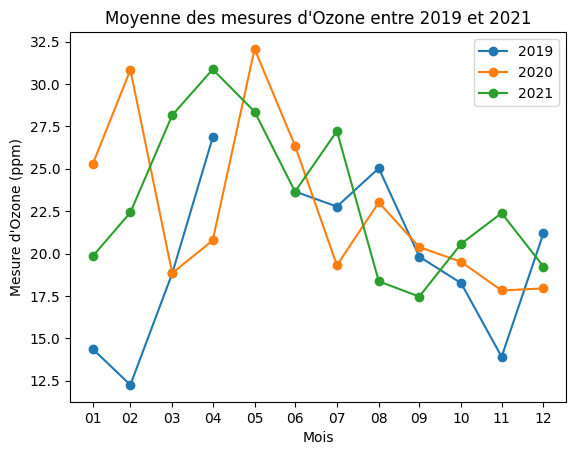

In [19]:
# Tracé des moyennes de microplastiques entre 2019 et 2021
plt.plot(df['date'], df['value_2019'], label='2019', marker='o')

plt.plot(df['date'], df['value_2020'], label='2020', marker='o')

plt.plot(df['date'], df['value_2021'], label='2021', marker='o')

# Ajout des titres et d'étiquettes
plt.title('Moyenne des mesures d\'Ozone entre 2019 et 2021')
plt.xlabel('Mois')
plt.ylabel('Mesure d\'Ozone (ppm)')

# Affichage de la légende
plt.legend()

# Modification des labels de l'axe des X
plt.xticks(df['date'], df['date'].dt.strftime('%m'))

# Affichage de la courbe
plt.show()

## 2. L'augmentation des types/unités de pollution

Cette analyse sera sur la partie pollution et les types de pollution. Nous n'utilisons pas les valeurs observées pour la température et les différences en température.

### Extraction des types de mesure

In [20]:
# Trouver les types unique
dataset["type"].unique()

array(['DiffTemp 2-8 m', 'Temp', 'Wind Direction 10 m', 'Wind Speed 10 m',
       'PM10', 'PM2.5', 'SO2', 'NO2', 'NO', 'PM25', 'Ozone', 'Pressure',
       'DiffTemp 8-22 m', 'Global Radiation', 'Max Wind Speed 10 m',
       'Max Wind Speed 24 m', 'Wind Direction 24 m', 'Wind Speed 24 m',
       'Rain'], dtype=object)

Notre analyse sera donc sur 'PM10', '**PM2.5**', 'SO2', 'NO2', 'NO', 'Ozone', '**PM25**'. Nous avons remarqué que les polluants PM 2.5 et PM25 sont les mêmes mesures. En dépit de cela, ces valeurs different et il existe des enregistrements différent pour une certaine DateTime. Face à ce problème, nous avons décidé de ne prendre que les valeurs pour PM2.5. Les particules fines sont définies comme des particules dont le diamètre est inférieur ou égal à 2,5 microns (PM2.5). Les PM2.5 comprennent une partie des PM10.

In [21]:
# Extraire les données dont nous avons besoin
polluants = ["PM2.5", "SO2", "NO2", "NO", "Ozone"]

# Application de l'extraction
df_polluant = dataset[dataset["type"].isin(polluants)]

# Vérification du succès de l'opération
df_polluant.head(n=10)

date     station   type  unite    valeur
5  2012-01-01 00:00:00  groundhog2  PM2.5  ugm-3  0.733333
11 2012-01-01 01:00:00  groundhog2  PM2.5  ugm-3  3.574997
17 2012-01-01 02:00:00  groundhog2  PM2.5  ugm-3  5.174995
23 2012-01-01 03:00:00  groundhog2  PM2.5  ugm-3  6.749992
29 2012-01-01 04:00:00  groundhog2  PM2.5  ugm-3  6.424995
35 2012-01-01 05:00:00  groundhog2  PM2.5  ugm-3  6.274994
41 2012-01-01 06:00:00  groundhog2  PM2.5  ugm-3  7.774994
47 2012-01-01 07:00:00  groundhog2  PM2.5  ugm-3  8.324997
53 2012-01-01 08:00:00  groundhog2  PM2.5  ugm-3  8.549988
59 2012-01-01 09:00:00  groundhog2  PM2.5  ugm-3  9.324982

### Conversion et manipulation des dates

In [22]:
# Conversion en date
df_polluant['date'] = pd.to_datetime(df_polluant['date'])

# Extraire l'année et le mois 
df_polluant['formatted_date'] = df_polluant['date'].dt.to_period('M')

# Group by par la date, les types et les valeurs
grouped_df = df_polluant.groupby(['formatted_date', 'type'])['valeur'].median().reset_index() # Nous prenons la médiane afind d'éviter le biais par les valeurs extrêmes.

# Extraire année et mois à nouveau
grouped_df['year'] = grouped_df['formatted_date'].dt.year
grouped_df['month'] = grouped_df['formatted_date'].dt.month

# Supprimer les dates formatées 
grouped_df = grouped_df.drop(columns=['formatted_date'])

# Rennommer les colonnes 
grouped_df.columns = ['Type', 'Valeur médiane', 'Année', 'Mois']

# Afficher le dataset aggrégé
print(grouped_df)

      Type  Valeur médiane  Année  Mois
0    PM2.5       12.874985   2012     1
1    PM2.5       14.124985   2012     2
2    PM2.5       18.787475   2012     3
3    PM2.5        9.537491   2012     4
4    PM2.5       13.724991   2012     5
..     ...             ...    ...   ...
268    NO2       13.227600   2021    11
269  Ozone       24.487518   2021    11
270     NO        3.618546   2021    12
271    NO2       14.697746   2021    12
272  Ozone       20.812515   2021    12

[273 rows x 4 columns]


/tmp/ipykernel_9603/1840474258.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_polluant['date'] = pd.to_datetime(df_polluant['date'])
/tmp/ipykernel_9603/1840474258.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_polluant['formatted_date'] = df_polluant['date'].dt.to_period('M')


### Heatmap des polluants de 2012 à 2021

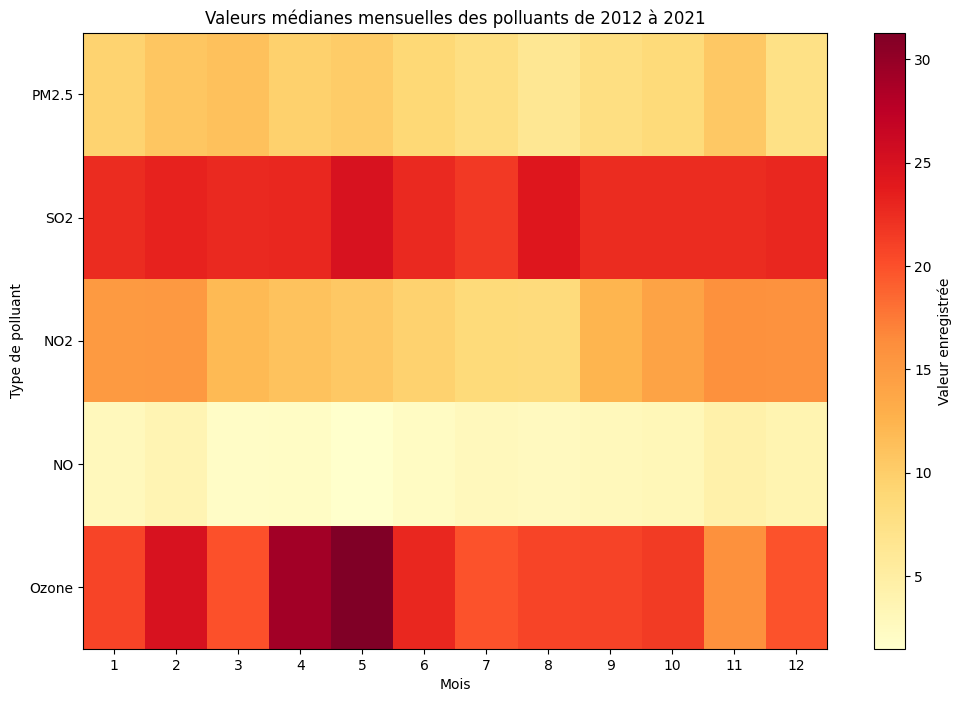

In [23]:
pollutants = grouped_df['Type'].unique()
months = sorted(grouped_df['Mois'].unique())

# Créer une matrice
heatmap_data = np.zeros((len(pollutants), len(months)))

# Ajouter à la matrice
for i, pollutant in enumerate(pollutants):
    for j, month in enumerate(months):
        median_value = grouped_df[(grouped_df['Type'] == pollutant) & (grouped_df['Mois'] == month)]['Valeur médiane'].median()
        heatmap_data[i, j] = median_value

# Créer la carte themique
plt.figure(figsize=(12, 8))
plt.imshow(heatmap_data, cmap='YlOrRd', aspect='auto', interpolation='nearest')

# Nommer les axes
plt.xticks(np.arange(len(months)), months)
plt.yticks(np.arange(len(pollutants)), pollutants)
plt.xlabel('Mois')
plt.ylabel('Type de polluant')
plt.title('Valeurs médianes mensuelles des polluants de 2012 à 2021')

# Ajouter la couleur
cbar = plt.colorbar()
cbar.set_label('Valeur enregistrée')

plt.show()

Le polluant Ozone se distingue des autres polluants. Faisons une étude plus approfondie sur cet élément afin de trouver une rélation entre lui et une variable météorologique.

In [24]:
selected_pollutants = ['SO2', 'Ozone', 'NO2','DiffTemp 8-22 m','Global Radiation', 'Max Wind Speed 24 m']

df_polluant_approf = dataset[dataset["type"].isin(selected_pollutants)]

df_polluant_approf.head(n = 10)

# Aggrégation des données
df_polluant_approf['date'] = pd.to_datetime(df_polluant_approf['date'])

# Extraire l'année et le mois 
df_polluant_approf['formatted_date'] = df_polluant_approf['date'].dt.to_period('M')

# Group by par la date, les types et les valeurs
grouped_df_app = df_polluant_approf.groupby(['formatted_date', 'type'])['valeur'].median().reset_index() # Nous prenons la médiane afin d'éviter le biais par les valeurs extrêmes.

# Extraire année et mois à nouveau
grouped_df_app['year'] = grouped_df_app['formatted_date'].dt.year
grouped_df_app['month'] = grouped_df_app['formatted_date'].dt.month

# Supprimer les dates formatées 
grouped_df_app = grouped_df_app.drop(columns=['formatted_date'])

# Rennommer les colonnes 
grouped_df_app.columns = ['Type', 'Valeur médiane', 'Année', 'Mois']

# Afficher le dataset aggrégé
print(grouped_df_app)

                    Type  Valeur médiane  Année  Mois
0                    SO2       13.480301   2012     6
1                    SO2       66.617798   2015     2
2                    SO2       11.599350   2016    11
3                    SO2       10.345367   2016    12
4                    SO2        7.994148   2017     1
..                   ...             ...    ...   ...
231      DiffTemp 8-22 m        0.005000   2021    12
232     Global Radiation        0.055000   2021    12
233  Max Wind Speed 24 m        4.435001   2021    12
234                  NO2       14.697746   2021    12
235                Ozone       20.812515   2021    12

[236 rows x 4 columns]


/tmp/ipykernel_9603/2280535574.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_polluant_approf['date'] = pd.to_datetime(df_polluant_approf['date'])
/tmp/ipykernel_9603/2280535574.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_polluant_approf['formatted_date'] = df_polluant_approf['date'].dt.to_period('M')


## Étude d'une corrélation

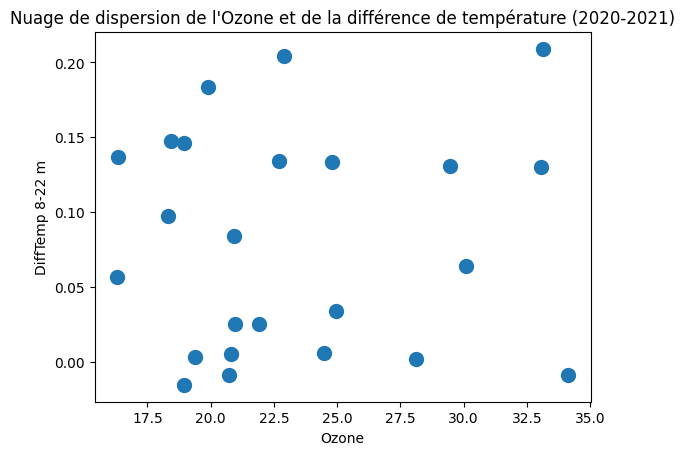

In [25]:
# Filtrer
df_2020_2021_ozone = grouped_df_app[(grouped_df_app['Type'] == 'Ozone') & (grouped_df_app['Année'].isin([2020, 2021]))]
df_2020_2021_diff_temp = grouped_df_app[(grouped_df_app['Type'] == 'DiffTemp 8-22 m') & (grouped_df_app['Année'].isin([2020, 2021]))]

# scatter plot avec Ozone sur x-axis et DiffTemp 8-22 m, y-axis pour les deux ans
plt.scatter(df_2020_2021_ozone['Valeur médiane'], df_2020_2021_diff_temp['Valeur médiane'], label='2020-2021', s=100)

# labels et titre
plt.xlabel('Ozone')
plt.ylabel('DiffTemp 8-22 m')
plt.title('Nuage de dispersion de l\'Ozone et de la différence de température (2020-2021)')


# Afficher le graphique
plt.show()

Évidemment, il existe peu de variation globale lorsque la variable Ozone change. Utilisons un indicateur statistique qui nous permettra de déterminer l'intensité de la corrélation.
L'ozone (O3) est un gaz très réactif composé de trois atomes d'oxygène. Il s'agit d'un gaz à la fois naturel et artificiel présent dans la haute atmosphère (stratosphère) et la basse atmosphère (troposphère) de la Terre. Il est présent dans la haute atmosphère (la stratosphère) et la basse atmosphère (la troposphère) de la Terre. Selon l'endroit où il se trouve dans l'atmosphère, l'ozone affecte la vie sur Terre de manière positive ou négative.

In [26]:
# Calculer le coeffiicient linéaire de Pearson
corr_coefficient, _ = pearsonr(df_2020_2021_ozone['Valeur médiane'], df_2020_2021_diff_temp['Valeur médiane'])

# Afficher le coefficient
print(f"Coefficient de Pearson (linéaire) : {round(corr_coefficient * 100,2)} %")

Coefficient de Pearson (linéaire) : 5.45 %


Il existe donc une corrélation linéaire très faible entre Ozone et la différence en temps 8-22m
Selon le scientifique Harvard Gazette, la production d'ozone s'accélère à des températures élevées et les émissions des composants naturels de l'ozone augmentent. Les températures élevées s'accompagnent également de vents faibles, ce qui entraîne une stagnation de l'atmosphère. L'air se réchauffe donc et les niveaux d'ozone peuvent s'accumuler". Notre étude montre une rélation faible entre Ozone est un composant de température. Voyons s'il y a une rélation faible entre le vent et Ozone.

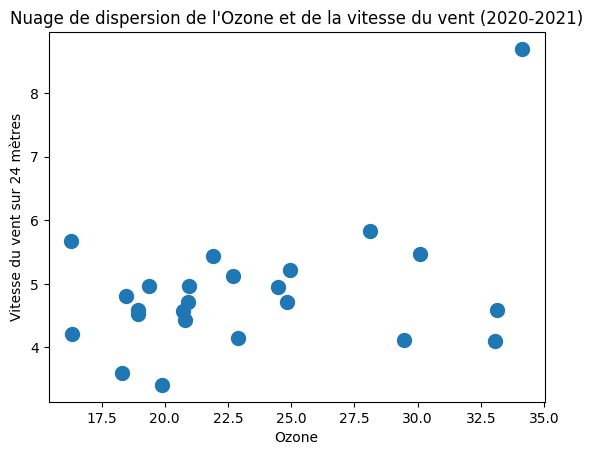

In [27]:
# Vent et Ozone
# Filtrer
df_2020_2021_ozone = grouped_df_app[(grouped_df_app['Type'] == 'Ozone') & (grouped_df_app['Année'].isin([2020, 2021]))]
df_2020_2021vent = grouped_df_app[(grouped_df_app['Type'] == 'Max Wind Speed 24 m') & (grouped_df_app['Année'].isin([2020, 2021]))]

# scatter plot avec Ozone sur x-axis et DiffTemp 8-22 m, y-axis pour les deux ans
plt.scatter(df_2020_2021_ozone['Valeur médiane'], df_2020_2021vent['Valeur médiane'], label='2020-2021', s=100)

# labels et titre
plt.xlabel('Ozone')
plt.ylabel('Vitesse du vent sur 24 mètres')
plt.title('Nuage de dispersion de l\'Ozone et de la vitesse du vent (2020-2021)')

# Afficher le graphique
plt.show()

En effet il y a peu de variation et les valeurs sont stables. Notez qu'il y a un croisement extrême. Il faudra supprimer cette valeur extrême afin d'éviter le biais dans le calcul du coefficient. Avec une augmentation d'Ozone, la vitesse max du vent à 24m reste globalement stable. Ceci confirme la connaissance générale dans ce domaine.

## Distribution des polluants

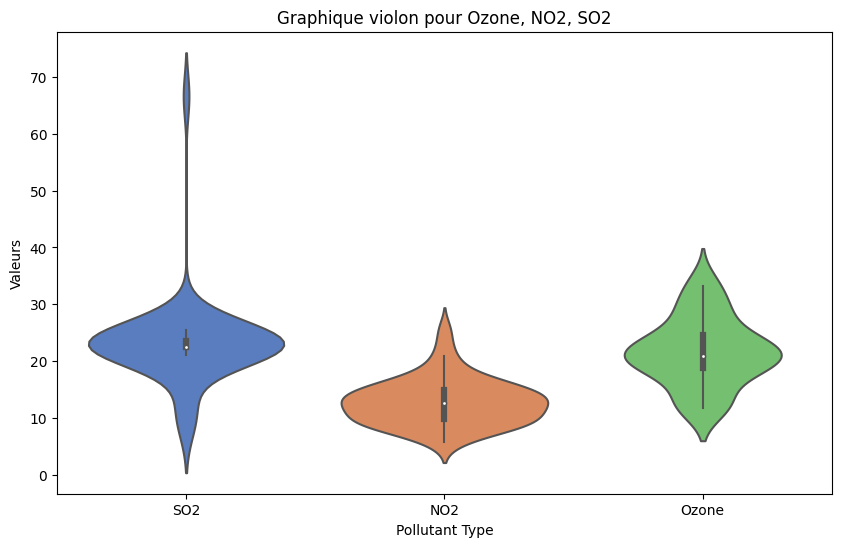

In [97]:
# Sélection des polluants pour notre analyse
selected_pollutants = ['Ozone', 'NO2', 'SO2']
filtered_data = grouped_df_app[grouped_df_app['Type'].isin(selected_pollutants)]

# Create a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Type', y='Valeur médiane', data=filtered_data, palette='muted')
plt.title('Graphique violon pour Ozone, NO2, SO2')
plt.xlabel('Pollutant Type')
plt.ylabel('Valeurs')
plt.show()

On peut observer que le SO2 à une majorité de valeurs se trouvent à plus de 20 ppm comme pour l'Ozone contre 10 ppm pour le NO2.